# Probabilistic Machine Learning - Project Report

**Course:** Probabilistic Machine Learning (SoSe 2025) <br>
**Lecturer:** Dr Alvaro Diaz-Ruelas <br>
**Student(s) Name(s):** Lukas Becker <br>
**GitHub Username(s):**  lbegit <br>
**Date:**  15052025 <br>
**PROJECT-ID:** 15-2BLXXXX_epa_census <br>

---

## 1 Introduction

In recent years, transportation equity and sustainability have become central concerns in urban planning and policy. Among the key indicators of social and infrastructural access is household vehicle ownership, particularly the percentage of households without access or need to a private vehicle. These zero-vehicle households are often more dependent on public transit and walkable environments, and their distribution is shaped by a complex mix of socio-economic, spatial, and infrastructural variables.

This research aims to predict the percentage of car-free households in new and changed US Census Block Groups (CBGs). It is using the US EPA’s Smart Location Database (SLD), a rich source of standardized spatial and socio-economic indicators. The focus is on identifying how evolving social, economic, or political changes, such as new transit infrastructure, economic shifts, or population dynamics, can influence car ownership trends.

To model these dynamics, I will explore a range of machine learning techniques, from linear models like OLS, Lasso, Ridge, Elastic Net, and Bayesian Ridge regression to more sophisticated approaches such as k-Nearest Neighbors, Random Forest and XGBoost. The goal is to determine which models best capture the nuanced, multidimensional patterns influencing car ownership at the CBG level.


The analysis will be conducted using a carefully selected subset of variables from the SLD dataset, chosen for their theoretical relevance and practical predictive potential. These features span demographic composition, employment density, urban design, and transit access. All of which are thought to influence household decisions regarding car ownership.

## 2 Data Loading and Exploration

### 2.1 Prerequisites

#### (i) Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression , Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
import statsmodels.api as sm
import xgboost as xgb


from sklearn.utils import resample
from tqdm import tqdm  # for progress bar

#### (ii) Functions

In [2]:
def compare_l1_l2_elastic(X_train, X_test, y_train, y_test, dataset_name):
    alphas = np.logspace(-3, 3, 50)
    lasso_mse = []
    ridge_mse = []
    elastic_mse = []

    for alpha in alphas:
        lasso = Lasso(alpha=alpha, max_iter=10000)
        ridge = Ridge(alpha=alpha)
        elastic = ElasticNet(alpha=alpha, l1_ratio=0.5, max_iter=10000)

        lasso.fit(X_train, y_train)
        ridge.fit(X_train, y_train)
        elastic.fit(X_train, y_train)

        y_pred_lasso = lasso.predict(X_test)
        y_pred_ridge = ridge.predict(X_test)
        y_pred_elastic = elastic.predict(X_test)

        lasso_mse.append(mean_squared_error(y_test, y_pred_lasso))
        ridge_mse.append(mean_squared_error(y_test, y_pred_ridge))
        elastic_mse.append(mean_squared_error(y_test, y_pred_elastic))

    plt.figure(figsize=(8,6))
    plt.plot(alphas, lasso_mse, label='Lasso (L1)', marker='o')
    plt.plot(alphas, ridge_mse, label='Ridge (L2)', marker='x')
    plt.plot(alphas, elastic_mse, label='Elastic Net', marker='s')
    plt.xscale('log')
    plt.xlabel('Regularization strength (alpha)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title(f'Comparison of L1, L2 and Elastic Net Regularization on {dataset_name} Dataset')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\nBest Lasso (L1) MSE for {dataset_name}: {np.min(lasso_mse):.3f} at alpha={alphas[np.argmin(lasso_mse)]:.3f}")
    print(f"Best Ridge (L2) MSE for {dataset_name}: {np.min(ridge_mse):.3f} at alpha={alphas[np.argmin(ridge_mse)]:.3f}")
    print(f"Best Elastic Net MSE for {dataset_name}: {np.min(elastic_mse):.3f} at alpha={alphas[np.argmin(elastic_mse)]:.3f}")



In [3]:
def metrics(y_test, y_pred):
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print results
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"R² (Coefficient of Determination): {r2:.4f}")

In [4]:
# Bootstrap parameters optimized for large dataset
N_BOOTSTRAP_SAMPLES = 1000  # Fewer samples needed with large N
BOOTSTRAP_SAMPLE_SIZE = 210000  
RANDOM_STATE = 43

def bootstrap_ols_coefficients(X, y, n_bootstrap=N_BOOTSTRAP_SAMPLES, 
                              sample_size=BOOTSTRAP_SAMPLE_SIZE, random_state=RANDOM_STATE):
    """
    Bootstrap OLS coefficients for large datasets
    Handles both numpy arrays and pandas DataFrames/Series correctly
    """
    np.random.seed(random_state)
    n_features = X.shape[1]
    bootstrap_coefs = np.zeros((n_bootstrap, n_features))
    
    #print(f"Running {n_bootstrap} bootstrap samples with {sample_size:,} records each...")
    #print(f"Data types: X={type(X)}, y={type(y)}")
    
    for i in tqdm(range(n_bootstrap)):
        # Resample with replacement
        boot_indices = np.random.choice(len(X), size=sample_size, replace=True)
        
        # Handle X indexing
        if hasattr(X, 'iloc'):  # pandas DataFrame
            X_boot = X.iloc[boot_indices]
        else:  # numpy array
            X_boot = X[boot_indices]
        
        # Handle y indexing
        if hasattr(y, 'iloc'):  
            y_boot = y.iloc[boot_indices]
        else:  # numpy array
            y_boot = y[boot_indices]
        
        # Convert to numpy if needed for sklearn
        if hasattr(X_boot, 'values'):
            X_boot = X_boot.values
        if hasattr(y_boot, 'values'):
            y_boot = y_boot.values
        
        # Fit OLS (using sklearn for speed)
        lr = LinearRegression(fit_intercept=True)
        lr.fit(X_boot, y_boot)
        bootstrap_coefs[i] = lr.coef_
    
    # Calculate mean and standard error
    mean_coefs = np.mean(bootstrap_coefs, axis=0)
    std_errors = np.std(bootstrap_coefs, axis=0, ddof=1)  # ddof=1 for sample std
    
    return mean_coefs, std_errors, bootstrap_coefs

#### (iii) Settings

In [5]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 1000) # Show all columns

### 2.2 Data

#### (i) Preselection of Features

In [6]:
#df = pd.read_csv('/Users/z3/Documents/Studium/1. Semester/ProbML/SmartLocation/EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv')

In [7]:
#selected_df = df[['STATEFP','COUNTYFP','TRACTCE','BLKGRPCE','CSA','CSA_Name','CBSA','CBSA_Name','CBSA_POP','CBSA_EMP','CBSA_WRK','TotPop','HH','P_WrkAge','Pct_AO0','Workers','R_PCTLOWWAGE','TotEmp','E_PctLowWage','D1A','D1B','D1C','D2A_JPHH','D3A','D4A','D4C']].rename(columns={
#'STATEFP': 'STATE_ID','COUNTYFP': 'COUNTY_ID','TRACTCE':'Tract_ID','BLKGRPCE':'Block_Group','CSA': 'CSA','CSA_Name': 'CSA_NAME','CBSA': 'CBSA','CBSA_Name': 'CBSA_NAME','CBSA_POP': 'CBSA_POP','CBSA_EMP': 'CBSA_EMP','CBSA_WRK': 'CBSA_WRK','TotPop': 'TOTAL_POPULATION','HH': 'HOUSEHOLDS','P_WrkAge': 'P_WORKING_AGE','Pct_AO0': 'P_ZERO_CARS_HOUSEHOLDS','Workers': 'WORKERS','R_PCTLOWWAGE': 'P_LOW_WAGE_WORKERS','TotEmp': 'TOTAL_EMPLOYMENT','E_PctLowWage': 'P_LOW_WAGE_EMPLOYMENT','D1A': 'HOUSEHOLD_P_ACRE','D1B': 'POPULATION_P_ACRE','D1C': 'JOBS_P_ACRE', 'D2A_JPHH' : 'JOBS_P_HOUSEHOLD','D3A': 'ROAD_NETWORK_MILES','D4A': 'METERS_NEXT_TRANSIT_STOP','D4C': 'TIMES_P_HOUR_TRANSIT_SERVICE'})


In [8]:
#selected_df.tob_csv('census_data', index=False) 

#### (ii) Feature Description 

| **Column Name**                | **Original Name** | **Description**                                         | **Important for Prediction?** | **Relevance to Car Ownership**                                                              |
| ------------------------------ | ----------------- | ------------------------------------------------------- | ----------------------------- | ------------------------------------------------------------------------------------------- |
| `STATE_ID`                     | `STATEFP`         | State FIPS                                              | No                            | Record identifier |
| `COUNTY_ID`                    | `COUNTYFP`        | County FIPS                                             | No                            | Record identifier |
| `Tract_ID`                     | `TRACTCE`         | Census Tract identifier                                | No                            | Record identifier |
| `Block_Group`                  | `BLKGRPCE`        | Census Block Group code                                | No                            | Record identifier |
| `CSA`                          | `CSA`             | Combined Statistical Area code                         | No                            | Record identifier |
| `CSA_NAME`                     | `CSA_Name`        | Name of the CSA                                        | No                            | Record identifier |
| `CBSA`                         | `CBSA`            | Core-Based Statistical Area code                       | No                            | Record identifier |
| `CBSA_NAME`                    | `CBSA_Name`       | Name of the CBSA                                       | No                            | Record identifier |
| `CBSA_POP`                     | `CBSA_POP`        | Total population in the CBSA                           | Yes                           | Indicates scale of urbanization, which affects transit and car dependency                  |
| `CBSA_EMP`                     | `CBSA_EMP`        | Total employment in CBSA                               | Yes                           | Economic size often correlates with public transportation investment and job accessibility |
| `CBSA_WRK`                     | `CBSA_WRK`        | Workers living in the CBSA                             | Yes                           | Reflects commuting patterns and urban form                                                 |
| `TOTAL_POPULATION`             | `TotPop`          | Total population of the CBG                            | Yes                           | More people can imply denser neighborhoods with better transit                             |
| `HOUSEHOLDS`                   | `HH`              | Number of occupied households                          | Yes                           | Base unit for computing car ownership and household ratios                                 |
| `P_WORKING_AGE`                | `P_WrkAge`        | Percent of population aged 18–64                       | Yes                           | Working-age population drives demand for work-related travel                               |
| `P_ZERO_CARS_HOUSEHOLDS`       | `Pct_AO0`         | Percent of households with zero cars                   | **Target**                    | **This is the variable being predicted**                                                   |
| `WORKERS`                      | `Workers`         | Count of workers living in CBG                         | Yes                           | High numbers of workers may increase car ownership unless transit is strong                |
| `P_LOW_WAGE_WORKERS`           | `R_PCTLOWWAGE`    | Share of workers earning ≤\$1,250/month                | Yes                           | Low-income households are more likely to be car-free                                       |
| `TOTAL_EMPLOYMENT`             | `TotEmp`          | Number of jobs located in the CBG                      | Yes                           | More nearby jobs may reduce need for car commuting                                         |
| `P_LOW_WAGE_EMPLOYMENT`        | `E_PctLowWage`    | Share of local jobs that are low wage                  | Yes                           | Indicates local affordability and types of employment accessible without a car             |
| `HOUSEHOLD_P_ACRE`             | `D1A`             | Residential density (HHs per acre of unprotected land) | Yes                           | Denser housing often supports transit and walking                                          |
| `POPULATION_P_ACRE`            | `D1B`             | Population density per acre                            | Yes                           | Key factor in predicting transit viability and car ownership                               |
| `JOBS_P_ACRE`                  | `D1C`             | Job density per acre                                   | Yes                           | Dense employment centers reduce reliance on personal vehicles                              |
| `JOBS_P_HOUSEHOLD`             | `D2A_JPHH`        | Ratio of jobs to households                            | Yes                           | Indicates job-housing balance, affecting travel needs                                      |
| `ROAD_NETWORK_MILES`      | `D3A`           | Miles roads per square mile           | Yes                           | Roads are mostly car-oriented infrastructure and often correlate with higher car ownership                |
| `METERS_NEXT_TRANSIT_STOP`     | `D4A`             | Distance to nearest transit stop (meters)              | Yes                           | Key factor—longer distances reduce the viability of car-free living                        |
| `TIMES_P_HOUR_TRANSIT_SERVICE` | `D4C`             | Frequency of transit service near CBG during peak hour | Yes                           | More frequent service supports households not owning cars                                  |


#### (iii) Load

In [9]:
# Load csv 
df_org = pd.read_csv('/Users/z3/Documents/Studium/1. Semester/ProbML/Probabilistic-Machine-Learning_lecture-PROJECTS/projects/15-2BLXXXX_epa_census/data/census_data')

In [10]:
df = df_org.copy()

### 2.3 Preparation

#### (i) Null-Values

In [11]:
df.isnull().sum()

STATE_ID                            0
COUNTY_ID                           0
Tract_ID                            0
Block_Group                         0
CSA                             53031
CSA_NAME                        53031
CBSA                            17095
CBSA_NAME                       17095
CBSA_POP                            0
CBSA_EMP                            0
CBSA_WRK                            0
TOTAL_POPULATION                    0
HOUSEHOLDS                        275
P_WORKING_AGE                       0
P_ZERO_CARS_HOUSEHOLDS              0
WORKERS                             0
P_LOW_WAGE_WORKERS                  0
TOTAL_EMPLOYMENT                    0
P_LOW_WAGE_EMPLOYMENT               0
HOUSEHOLD_P_ACRE                  271
POPULATION_P_ACRE                   0
JOBS_P_ACRE                         0
JOBS_P_HOUSEHOLD                    0
ROAD_NETWORK_MILES                  0
METERS_NEXT_TRANSIT_STOP            0
TIMES_P_HOUR_TRANSIT_SERVICE        0
dtype: int64

##### Missing CSA and CBSA Values
I have a lot of Null-Values in CSA and CBSA Columns. These are just additional location information and no features. I will not use them in the model. They are only useful to get information about individual elements. But they are correlated with zero values in CBSA_POP, CBSA_EMP, CBSA_WRK. These Features should and will not be used in the model. 

In [12]:
df[(df['CBSA_POP']==0) | (df['CBSA_EMP']==0) | (df['CBSA_WRK']==0)]

,STATE_ID,COUNTY_ID,Tract_ID,Block_Group,CSA,CSA_NAME,CBSA,CBSA_NAME,CBSA_POP,CBSA_EMP,CBSA_WRK,TOTAL_POPULATION,HOUSEHOLDS,P_WORKING_AGE,P_ZERO_CARS_HOUSEHOLDS,WORKERS,P_LOW_WAGE_WORKERS,TOTAL_EMPLOYMENT,P_LOW_WAGE_EMPLOYMENT,HOUSEHOLD_P_ACRE,POPULATION_P_ACRE,JOBS_P_ACRE,JOBS_P_HOUSEHOLD,ROAD_NETWORK_MILES,METERS_NEXT_TRANSIT_STOP,TIMES_P_HOUR_TRANSIT_SERVICE
78,48,421,950200,2,NaN,NaN,NaN,NaN,0,0,0,1718,585.0,0.590,0.034188,454,0.196035,611,0.170213,1.038652,2.541886,0.904012,1.044444,21.685255,-99999.0,-99999.0
301,48,331,950700,3,NaN,NaN,NaN,NaN,0,0,0,541,220.0,0.416,0.068182,402,0.233831,245,0.200000,0.250029,0.491875,0.222753,1.113636,7.396807,-99999.0,-99999.0
302,48,331,950700,4,NaN,NaN,NaN,NaN,0,0,0,861,431.0,0.696,0.081206,419,0.264916,300,0.186667,0.817271,1.453864,0.506573,0.696056,13.665453,-99999.0,-99999.0
303,48,331,950700,5,NaN,NaN,NaN,NaN,0,0,0,2513,908.0,0.526,0.000000,769,0.221066,131,0.282443,0.882287,2.441836,0.127290,0.144273,9.107649,-99999.0,-99999.0
307,48,207,950300,3,NaN,NaN,NaN,NaN,0,0,0,824,336.0,0.525,0.065476,371,0.304582,83,0.277108,0.559090,1.104773,0.111282,0.247024,11.356720,-99999.0,-99999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220735,78,30,961000,2,NaN,NaN,NaN,NaN,0,0,0,1471,573.0,0.000,0.000000,0,0.000000,0,0.000000,8.761019,18.813808,0.000000,0.000000,33.948142,-99999.0,-99999.0
220736,78,30,961000,3,NaN,NaN,NaN,NaN,0,0,0,940,418.0,0.000,0.000000,0,0.000000,0,0.000000,8.040306,13.008412,0.000000,0.000000,39.675163,-99999.0,-99999.0
220737,78,30,961000,5,NaN,NaN,NaN,NaN,0,0,0,878,403.0,0.000,0.000000,0,0.000000,0,0.000000,12.545333,21.941838,0.000000,0.000000,32.111446,-99999.0,-99999.0
220738,78,30,960700,3,NaN,NaN,NaN,NaN,0,0,0,1278,613.0,0.000,0.000000,0,0.000000,0,0.000000,1.404107,1.485471,0.000000,0.000000,14.657562,-99999.0,-99999.0


##### Missing Households Values

In [13]:
# Comparing households_null_values with special_territories with state identity 66 and 69

households_null_df = df[df['HOUSEHOLDS'].isnull() | df['HOUSEHOLD_P_ACRE'].isnull()]
special_territories_df = df[df['STATE_ID'].isin([66, 69])] 

same_indices = households_null_df.index.equals(special_territories_df.index)
print(same_indices)  # True if exactly same rows selected

True


The values match the total number of elements from "Northern Mariana Islands" and "Guam". Because they are missing in total and this are special territories, I will drop them. I also will drop other special territories which are not American states:

In [14]:
# Drop all special territories
df = df[df['STATE_ID']<=56] 

#### (ii) Values

In [15]:
df.describe()

,STATE_ID,COUNTY_ID,Tract_ID,Block_Group,CSA,CBSA,CBSA_POP,CBSA_EMP,CBSA_WRK,TOTAL_POPULATION,HOUSEHOLDS,P_WORKING_AGE,P_ZERO_CARS_HOUSEHOLDS,WORKERS,P_LOW_WAGE_WORKERS,TOTAL_EMPLOYMENT,P_LOW_WAGE_EMPLOYMENT,HOUSEHOLD_P_ACRE,POPULATION_P_ACRE,JOBS_P_ACRE,JOBS_P_HOUSEHOLD,ROAD_NETWORK_MILES,METERS_NEXT_TRANSIT_STOP,TIMES_P_HOUR_TRANSIT_SERVICE
count,217739.000000,217739.000000,217739.000000,217739.000000,165358.000000,201066.000000,2.177390e+05,2.177390e+05,2.177390e+05,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000
mean,28.032071,85.893896,260341.890681,2.222836,339.877611,30438.240379,3.640101e+06,1.706534e+06,1.657484e+06,1482.982056,549.879112,0.596186,0.092067,646.607498,0.237747,647.915008,0.295959,4.525163,10.445416,3.825622,1.793225,15.762961,-56542.004006,-53413.498352
std,15.697888,99.319321,350582.092807,1.195316,125.530744,10955.270410,5.246923e+06,2.487643e+06,2.409038e+06,990.394957,339.914770,0.102778,0.135699,416.995859,0.056450,2033.839914,0.151614,13.938563,29.280778,46.708921,38.854630,10.709707,49768.726104,49889.750594
min,1.000000,1.000000,100.000000,0.000000,104.000000,10100.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-99999.000000,-99999.000000
25%,13.000000,29.000000,10300.000000,1.000000,216.000000,19740.000000,2.058140e+05,8.365800e+04,8.366200e+04,891.000000,342.000000,0.544000,0.010289,391.000000,0.203509,73.000000,0.191916,0.295216,0.701898,0.085160,0.151659,5.605491,-99999.000000,-99999.000000
50%,28.000000,61.000000,43900.000000,2.000000,356.000000,32580.000000,1.252890e+06,5.950500e+05,5.656950e+05,1267.000000,477.000000,0.595000,0.043400,555.000000,0.232787,205.000000,0.281481,1.841697,4.318367,0.555907,0.406849,15.643013,-99999.000000,-99999.000000
75%,41.000000,109.000000,480400.000000,3.000000,428.000000,39150.000000,4.673634e+06,2.400290e+06,2.241034e+06,1818.000000,674.000000,0.649000,0.113757,797.000000,0.267123,557.000000,0.381818,4.140478,10.095174,2.200705,1.070707,23.363958,346.010000,4.670000
max,56.000000,840.000000,992201.000000,9.000000,566.000000,49820.000000,1.931847e+07,9.159786e+06,8.946175e+06,55407.000000,21337.000000,1.000000,1.000000,19255.000000,1.000000,266101.000000,1.000000,1481.257220,3133.578265,14032.760640,12325.666670,166.894521,1207.000000,973.670000


##### High values of population

In [16]:
df[df['TOTAL_POPULATION']>30000]

,STATE_ID,COUNTY_ID,Tract_ID,Block_Group,CSA,CSA_NAME,CBSA,CBSA_NAME,CBSA_POP,CBSA_EMP,CBSA_WRK,TOTAL_POPULATION,HOUSEHOLDS,P_WORKING_AGE,P_ZERO_CARS_HOUSEHOLDS,WORKERS,P_LOW_WAGE_WORKERS,TOTAL_EMPLOYMENT,P_LOW_WAGE_EMPLOYMENT,HOUSEHOLD_P_ACRE,POPULATION_P_ACRE,JOBS_P_ACRE,JOBS_P_HOUSEHOLD,ROAD_NETWORK_MILES,METERS_NEXT_TRANSIT_STOP,TIMES_P_HOUR_TRANSIT_SERVICE
1232,48,157,672900,1,288.0,"Houston-The Woodlands, TX",26420.0,"Houston-The Woodlands-Sugar Land, TX",6779104,2975382,2886903,51536,15407.0,0.627,0.002402,18918,0.186330,3017,0.421279,1.374236,4.410976,0.258226,0.195820,14.486178,-99999.00,-99999.00
14654,48,157,673101,1,288.0,"Houston-The Woodlands, TX",26420.0,"Houston-The Woodlands-Sugar Land, TX",6779104,2975382,2886903,55407,15298.0,0.561,0.010132,14430,0.152460,17541,0.202839,1.742049,6.051140,1.915697,1.146620,18.092143,-99999.00,-99999.00
41412,6,73,18700,1,NaN,NaN,41740.0,"San Diego-Chula Vista-Carlsbad, CA",3302833,1403191,1419381,38932,6877.0,0.748,0.000000,6608,0.236229,1848,0.174242,0.057605,0.293930,0.013952,0.268722,2.366354,-99999.00,12.00
63625,12,119,911200,1,422.0,"Orlando-Lakeland-Deltona, FL",45540.0,"The Villages, FL",120999,25547,23986,39919,21337.0,0.198,0.015091,5856,0.400615,5409,0.317989,2.401617,3.626500,0.491389,0.253503,16.229679,-99999.00,-99999.00
69848,12,95,16730,1,422.0,"Orlando-Lakeland-Deltona, FL",36740.0,"Orlando-Kissimmee-Sanford, FL",2450261,1262313,1135710,31938,10189.0,0.603,0.024438,14402,0.205458,2278,0.366550,1.970425,5.639018,0.402207,0.223574,11.420017,-99999.00,0.33
170662,38,17,40500,2,244.0,"Fargo-Wahpeton, ND-MN",22020.0,"Fargo, ND-MN",237003,137770,122263,39283,15893.0,0.665,0.032908,19255,0.188990,11131,0.250292,0.565242,1.300023,0.368367,0.700371,7.012611,380.88,3.00


Unusually high values of population checked; Example Element 14654 validated by https://datacommons.org/browser/geoId/481576731011

Theory: I think this high values exist because of rapid population growth.

#### (iv) Final data selection

In [17]:
feature_df = df.iloc[:, 11:].copy()
#feature_df = feature_df.drop('POPULATION_P_ACRE', axis=1)

## 3 Data Preprocessing

### 3.1 Feature Engineering

#### Threshold Values for Transit Features:

METERS_NEXT_TRANSIT_ STOP: 'All CBGs with population-weighted centroids that were further than three-quarter miles (12 km) from a transit stop were assigned a value of “-99999”'

This are bad placeholders because it should be a high positive value to show that a transit stop is far away

In [18]:
#feature_df[feature_df['METERS_NEXT_TRANSIT_STOP']==-99999]

TIMES_P_HOUR_TRANSIT_SERVICE: 'CBGs in areas that do not have transit service were assigned the value “-99999”'

This are bad placeholders because it should be a zero to show that there is 0 times per hour

In [19]:
#feature_df[feature_df['TIMES_P_HOUR_TRANSIT_SERVICE']==-99999]

In [20]:
# Replacing placeholder values with null
feature_df['METERS_NEXT_TRANSIT_STOP'] = feature_df['METERS_NEXT_TRANSIT_STOP'].replace(-99999, np.nan)
feature_df['TIMES_P_HOUR_TRANSIT_SERVICE'] = feature_df['TIMES_P_HOUR_TRANSIT_SERVICE'].replace(-99999, np.nan)

# Create new binary feature no_transit
feature_df.loc[:, 'no_transit'] = feature_df['METERS_NEXT_TRANSIT_STOP'].isna().astype(int)

# Fill Features with suiting values
feature_df.loc[:, 'METERS_NEXT_TRANSIT_STOP'] = feature_df['METERS_NEXT_TRANSIT_STOP'].fillna(2000) # max of other data is 1200
feature_df.loc[:, 'TIMES_P_HOUR_TRANSIT_SERVICE'] = feature_df['TIMES_P_HOUR_TRANSIT_SERVICE'].fillna(0) # minimum value of zero

<span style="color:red">Question: </span> Is changing values like this legitimate?

In [21]:
feature_df.describe()

,TOTAL_POPULATION,HOUSEHOLDS,P_WORKING_AGE,P_ZERO_CARS_HOUSEHOLDS,WORKERS,P_LOW_WAGE_WORKERS,TOTAL_EMPLOYMENT,P_LOW_WAGE_EMPLOYMENT,HOUSEHOLD_P_ACRE,POPULATION_P_ACRE,JOBS_P_ACRE,JOBS_P_HOUSEHOLD,ROAD_NETWORK_MILES,METERS_NEXT_TRANSIT_STOP,TIMES_P_HOUR_TRANSIT_SERVICE,no_transit
count,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000
mean,1482.982056,549.879112,0.596186,0.092067,646.607498,0.237747,647.915008,0.295959,4.525163,10.445416,3.825622,1.793225,15.762961,1331.240828,6.806150,0.567390
std,990.394957,339.914770,0.102778,0.135699,416.995859,0.056450,2033.839914,0.151614,13.938563,29.280778,46.708921,38.854630,10.709707,787.794129,22.654669,0.495439
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,891.000000,342.000000,0.544000,0.010289,391.000000,0.203509,73.000000,0.191916,0.295216,0.701898,0.085160,0.151659,5.605491,457.320000,0.000000,0.000000
50%,1267.000000,477.000000,0.595000,0.043400,555.000000,0.232787,205.000000,0.281481,1.841697,4.318367,0.555907,0.406849,15.643013,2000.000000,0.000000,1.000000
75%,1818.000000,674.000000,0.649000,0.113757,797.000000,0.267123,557.000000,0.381818,4.140478,10.095174,2.200705,1.070707,23.363958,2000.000000,4.670000,1.000000
max,55407.000000,21337.000000,1.000000,1.000000,19255.000000,1.000000,266101.000000,1.000000,1481.257220,3133.578265,14032.760640,12325.666670,166.894521,2000.000000,973.670000,1.000000


In [22]:
feature_df['P_ZERO_CARS_HOUSEHOLDS'].describe()

count    217739.000000
mean          0.092067
std           0.135699
min           0.000000
25%           0.010289
50%           0.043400
75%           0.113757
max           1.000000
Name: P_ZERO_CARS_HOUSEHOLDS, dtype: float64

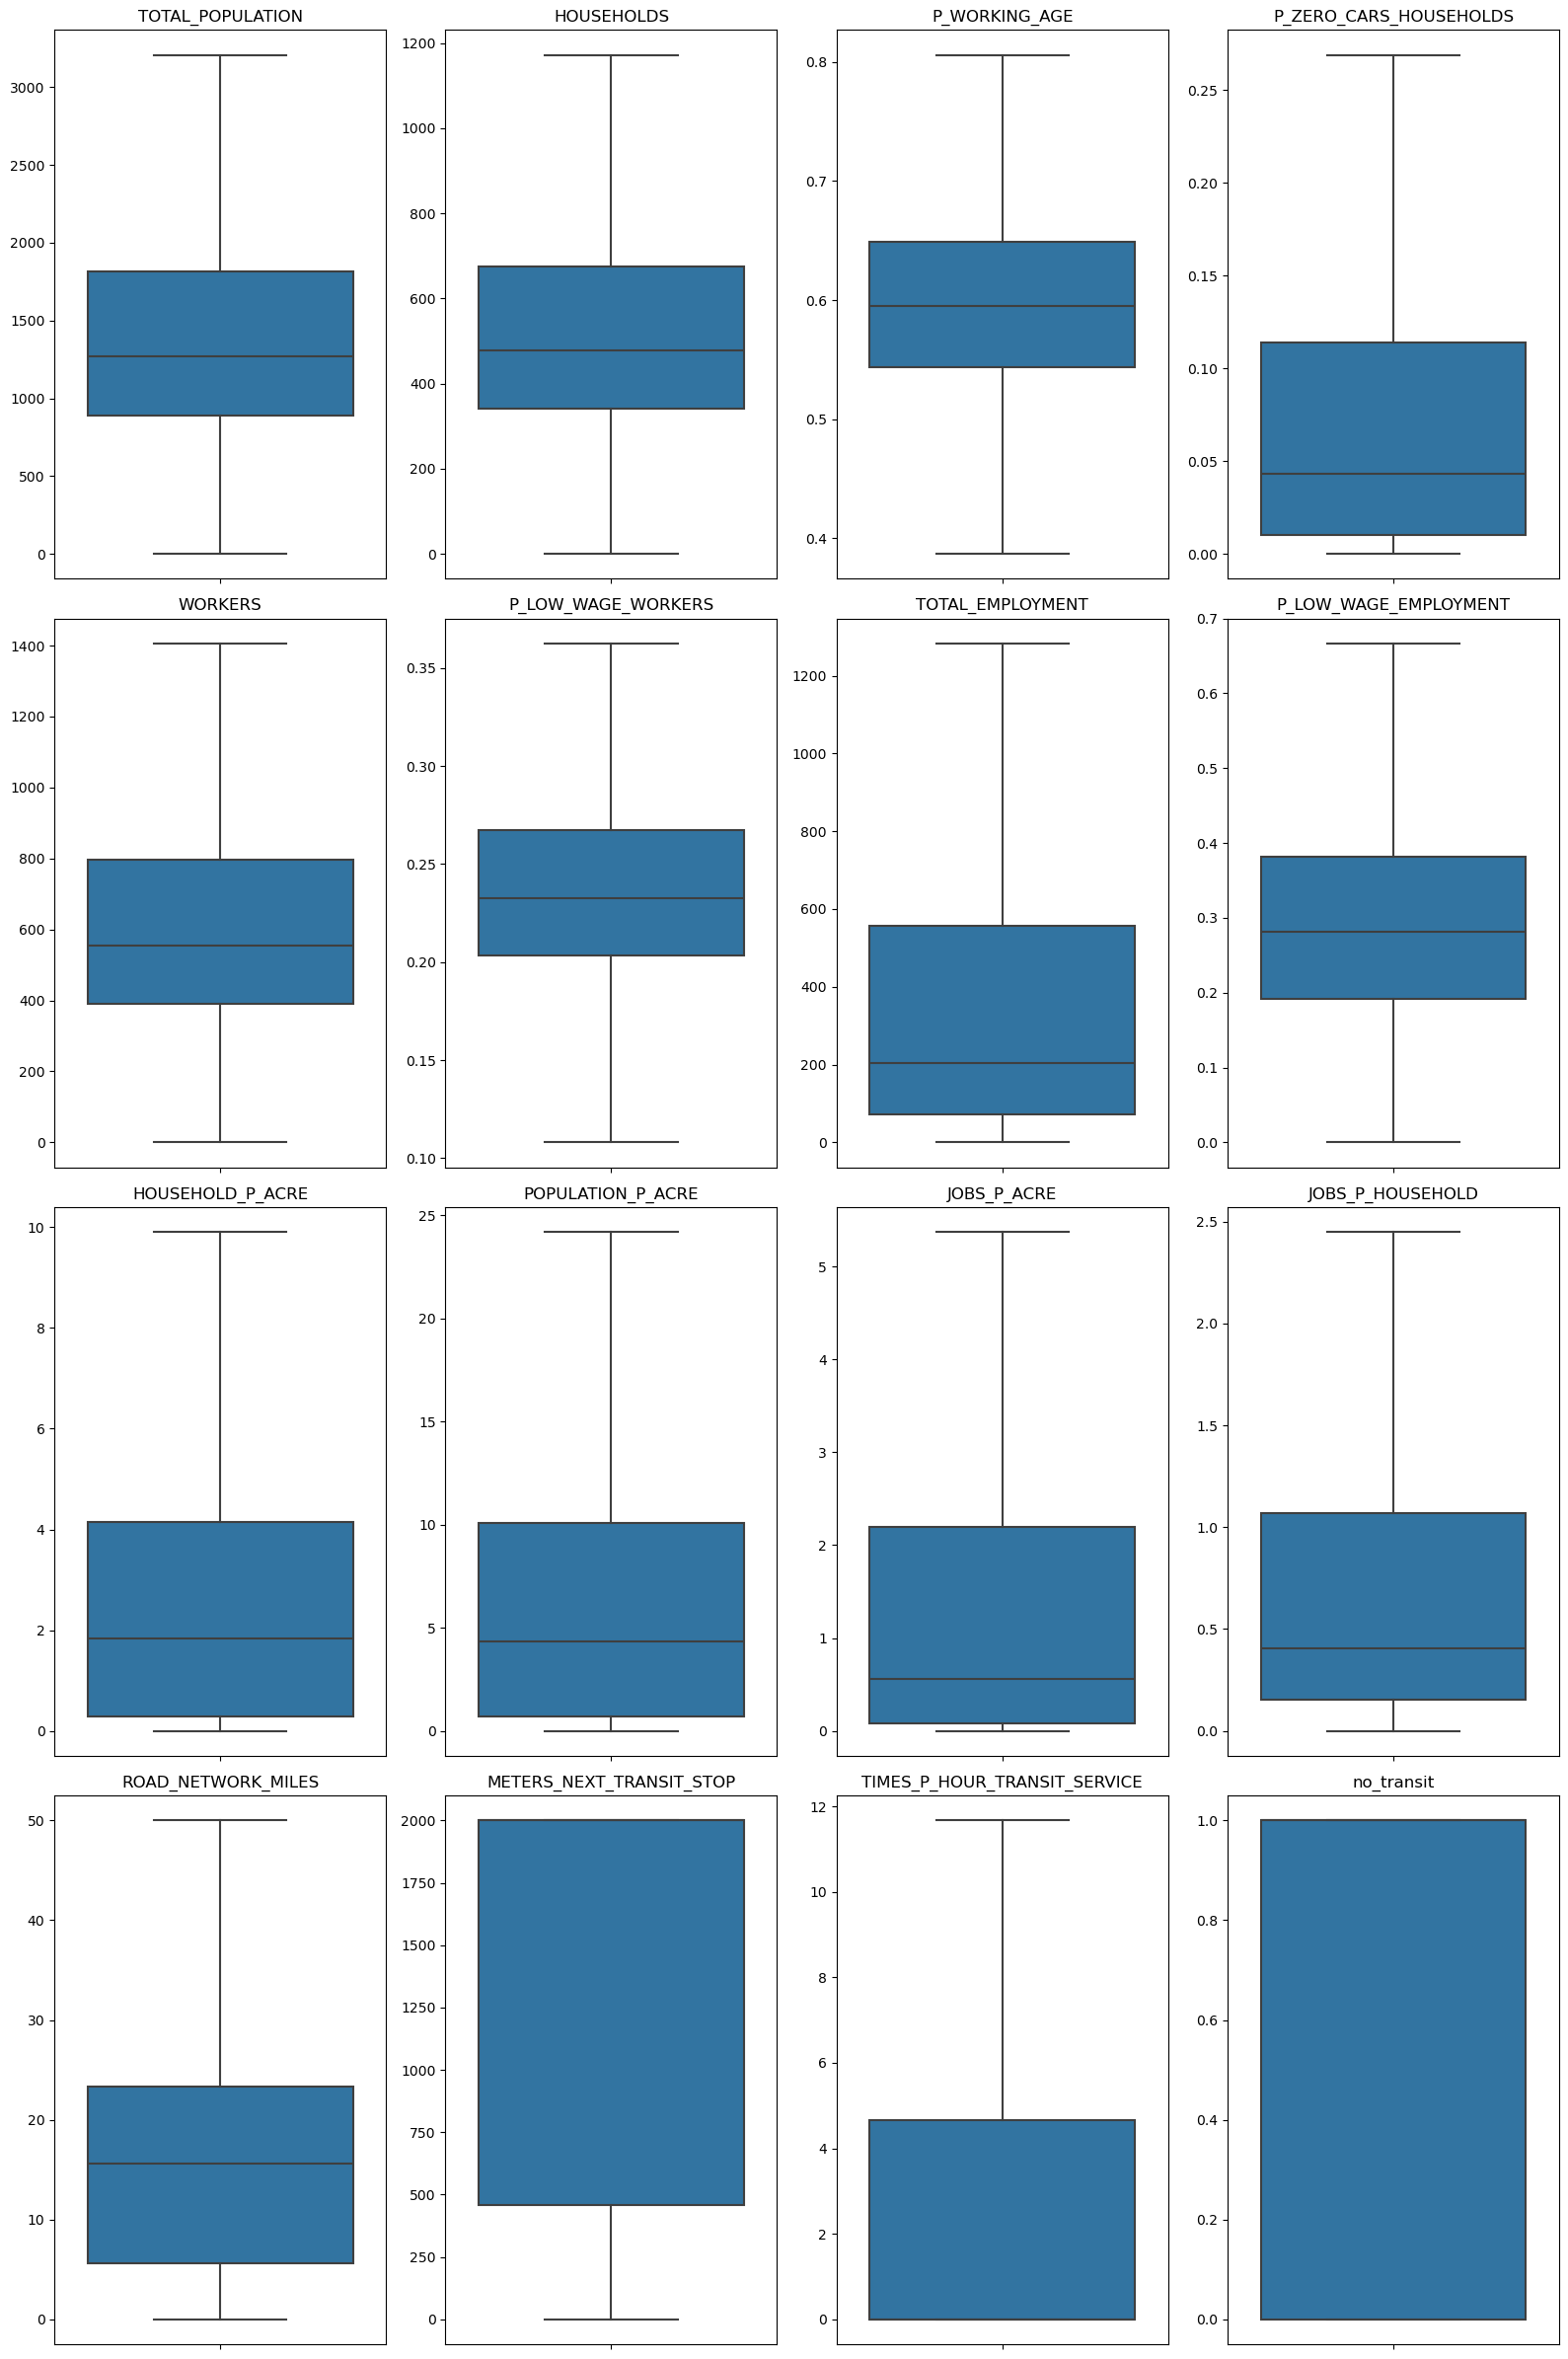

In [23]:
feature_df_numeric = feature_df.iloc[:, :]
num_cols = feature_df_numeric.shape[1]

# Create subplots: 4 rows and 4 columns
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(4 * 4, 6 * 4), sharey=False)

# Flatten the 2D axes array for easier iteration
axes = axes.flatten()

# Plot each column in its own subplot
for i, col in enumerate(feature_df_numeric.columns):
    sns.boxplot(y=feature_df_numeric[col], ax=axes[i], showfliers=False)
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')


plt.tight_layout()
plt.show()

In [24]:
print((feature_df == 0).sum())

TOTAL_POPULATION                  1057
HOUSEHOLDS                        1507
P_WORKING_AGE                     1081
P_ZERO_CARS_HOUSEHOLDS           49123
WORKERS                            705
P_LOW_WAGE_WORKERS                 871
TOTAL_EMPLOYMENT                  2162
P_LOW_WAGE_EMPLOYMENT             4426
HOUSEHOLD_P_ACRE                  1455
POPULATION_P_ACRE                 1058
JOBS_P_ACRE                       2166
JOBS_P_HOUSEHOLD                  2924
ROAD_NETWORK_MILES                 586
METERS_NEXT_TRANSIT_STOP          3106
TIMES_P_HOUR_TRANSIT_SERVICE    116318
no_transit                       94196
dtype: int64


The distributions look plausible.

<span style="color:red">Question: </span> 

I have a lot of elements which have no_transit: 56%. Does this effect my regression in any way?

Do I have to handle strong outliers like POPULATION_P_ACRE with max: 3133 and mean: 10?

### 3.2 Correlation

In [25]:
#feature_df

In [26]:
correlation_matrix = feature_df.corr(numeric_only=True)

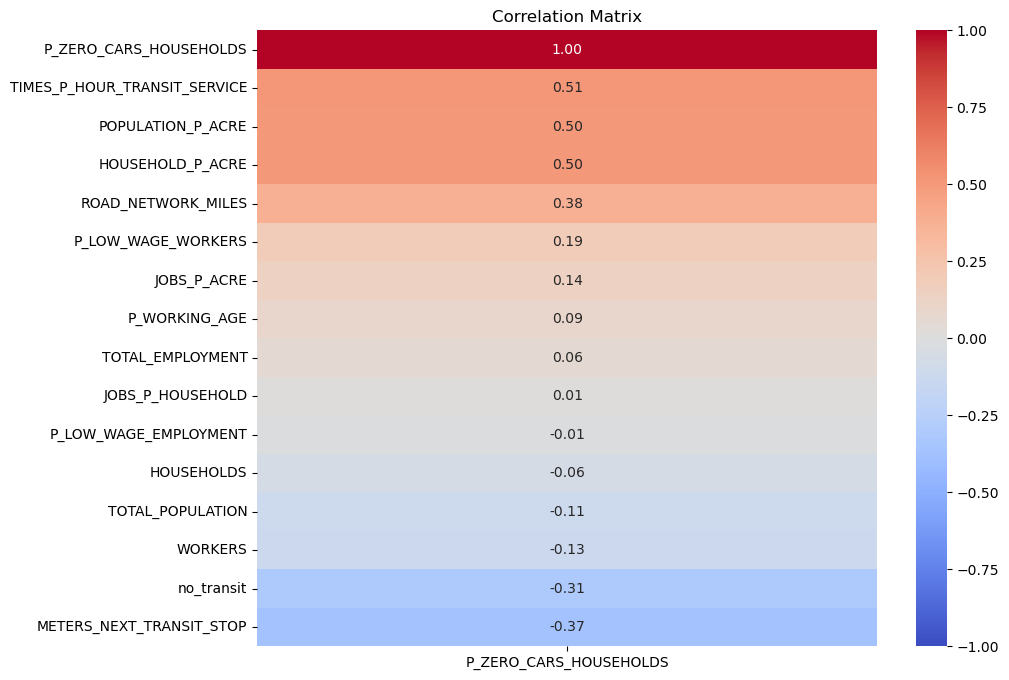

In [27]:
target_feature = "P_ZERO_CARS_HOUSEHOLDS"

correlation_with_target = correlation_matrix[[target_feature]].sort_values(by=target_feature, ascending=False)

plt.figure(figsize=(10, 8))
#sns.heatmap(correlation_matrix.round(2), annot=False, cmap='coolwarm', fmt="2f")
sns.heatmap(correlation_with_target.round(2), annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

There are some pairs of variables displaying significant correlation.

## 4 Probabilistic Modeling Approach

\section{Probabilistic Modeling Approach}

### 4.1 Linear Models

#### (i) **Ordinary Least Squares (OLS)**

OLS minimizes the residual sum of squares:

$$
\hat{\beta} = \arg\min_{\beta} \| y - X\beta \|^2
$$

**Suitability**: Serves as a baseline due to its interpretability and closed-form solution. May overfit in the presence of multicollinearity or noisy features.

---

#### (ii) **Ridge Regression (L2 Regularization)**

Introduces an L2 penalty on the coefficients:

$$
\hat{\beta}_{\text{ridge}} = \arg\min_{\beta} \| y - X\beta \|^2 + \lambda \| \beta \|_2^2
$$

**Suitability**: Controls overfitting by shrinking coefficients. Effective with correlated predictors.

---

#### (iii) **Lasso Regression (L1 Regularization)**

Introduces an L1 penalty:

$$
\hat{\beta}_{\text{lasso}} = \arg\min_{\beta} \| y - X\beta \|^2 + \lambda \| \beta \|_1
$$

**Suitability**: Encourages sparsity and performs automatic feature selection.

---

#### (iv) **Elastic Net**

Combines L1 and L2 regularization:

$$
\hat{\beta}_{\text{EN}} = \arg\min_{\beta} \| y - X\beta \|^2 + \lambda_1 \| \beta \|_1 + \lambda_2 \| \beta \|_2^2
$$

**Suitability**: Balances sparsity and regularization. Useful for correlated features.

---

#### (v) **Bayesian Ridge Regression**

A probabilistic version of Ridge regression with priors:

$$
p(\beta) = \mathcal{N}(0, \alpha^{-1} I), \quad p(y \mid X, \beta) = \mathcal{N}(X\beta, \eta^{-1} I)
$$

Posterior distribution:

$$
p(\beta \mid D) = \mathcal{N}(\mathbf{m}_N, \mathbf{S}_N)
$$

$$
\mathbf{S}_N = (\alpha I + \eta X^T X)^{-1}, \quad \mathbf{m}_N = \eta \mathbf{S}_N X^T y
$$

**Suitability**: Captures uncertainty in weights and includes automatic regularization.

---

### 4.2 Nonlinear Models

To address potential nonlinear relationships in the data, the following models are considered.

---

#### (i) **k-Nearest Neighbors (k-NN) Regression**

Predicts by averaging target values of the $k$ nearest neighbors:

$$
\hat{y}(x) = \frac{1}{k} \sum_{i \in \mathcal{N}_k(x)} y_i
$$

**Suitability**: Non-parametric, data-driven. Best for low-dimensional, smooth problems.

---

#### (ii) **Decision Tree Regression**

Recursively partitions the feature space to minimize within-node variance:

$$
\text{MSE}(S) = \frac{1}{|S|} \sum_{i \in S} (y_i - \bar{y}_S)^2
$$

**Suitability**: Captures nonlinear relationships and interactions. Interpretable but prone to overfitting without regularization.

---

#### (iii) **Random Forest Regression**

An ensemble of decision trees trained on bootstrapped samples:

$$
\hat{y} = \frac{1}{T} \sum_{t=1}^{T} f_t(x)
$$

**Suitability**: Reduces overfitting compared to a single tree. Robust and effective for tabular data.

---

#### (iv) **XGBoost Regression**

Implements gradient boosting by sequentially adding trees to correct previous errors, with regularization to control complexity:

$$
\hat{y}^{(t)} = \hat{y}^{(t-1)} + \eta f_t(x), \quad f_t \in \mathcal{F}
$$

**Suitability**: Highly efficient and accurate. Handles complex nonlinear relationships, large datasets, and high-dimensional feature spaces.

---

### 4.3 Summary of Suitability

| Model           | Strengths                                   | When to Use                                 |
|-----------------|---------------------------------------------|---------------------------------------------|
| OLS             | Simple, interpretable                       | Linear relationships                        |
| Ridge           | Handles multicollinearity                   | Correlated predictors                        |
| Lasso           | Feature selection                           | Sparse models                               |
| Elastic Net     | Hybrid regularization                       | Correlated + sparse features                |
| Bayesian Ridge  | Uncertainty-aware, regularized               | Noisy/small data                            |
| k-NN            | Local, non-parametric                       | Small, low-dim, smooth data                 |
| Decision Tree   | Nonlinear, interpretable                     | Simple, explainable models                  |
| Random Forest   | Nonlinear, robust                           | Tabular data, interactions                  |
| XGBoost         | High accuracy, efficient                    | Large, complex datasets                     |


## 5 Model Training, Evaluation, Results and Discussion

### 5.1 Data

#### (i) Overview

In [28]:
feature_df

,TOTAL_POPULATION,HOUSEHOLDS,P_WORKING_AGE,P_ZERO_CARS_HOUSEHOLDS,WORKERS,P_LOW_WAGE_WORKERS,TOTAL_EMPLOYMENT,P_LOW_WAGE_EMPLOYMENT,HOUSEHOLD_P_ACRE,POPULATION_P_ACRE,JOBS_P_ACRE,JOBS_P_HOUSEHOLD,ROAD_NETWORK_MILES,METERS_NEXT_TRANSIT_STOP,TIMES_P_HOUR_TRANSIT_SERVICE,no_transit
0,1202,423.0,0.549,0.163121,412,0.240291,66,0.318182,6.250422,16.332625,0.896800,0.156028,23.534900,362.10,4.33,0
1,710,409.0,0.466,0.000000,395,0.192405,25,0.400000,3.430799,5.955666,0.209707,0.061125,22.893366,718.84,4.33,0
2,737,329.0,0.811,0.057751,463,0.293737,0,0.000000,13.843035,27.951553,0.000000,0.000000,14.210509,398.31,3.00,0
3,904,384.0,0.638,0.000000,431,0.139211,253,0.478261,3.225246,7.592767,2.124967,0.658854,32.178373,386.24,6.67,0
4,948,343.0,0.506,0.014577,579,0.157168,32,0.187500,2.305992,6.373413,0.215136,0.093294,22.058651,638.37,6.67,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217734,1251,557.0,0.580,0.034111,601,0.221298,49,0.306122,3.166905,6.737752,0.263909,0.087971,23.012779,2000.00,0.00,1
217735,1292,473.0,0.593,0.000000,513,0.214425,310,0.203226,1.330228,3.430449,0.823095,0.655391,20.675338,2000.00,0.00,1
217736,1055,456.0,0.596,0.046053,494,0.251012,228,0.478070,3.702966,8.567168,1.851483,0.500000,28.198149,2000.00,0.00,1
217737,833,425.0,0.586,0.120000,351,0.236467,497,0.271630,0.002295,0.003756,0.002241,1.169412,0.799596,2000.00,0.00,1


#### (ii) Splitting

In [29]:
y = feature_df["P_ZERO_CARS_HOUSEHOLDS"]
X = feature_df.drop(columns=["P_ZERO_CARS_HOUSEHOLDS","no_transit"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

#### (iii) Standardization

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 5.2 Linear Models

#### (i) OLS

In [31]:
model = LinearRegression()
OLS_model = model.fit(X_train_scaled, y_train)
y_pred = OLS_model.predict(X_test_scaled)

metrics(y_test, y_pred)

Mean Squared Error (MSE): 0.009574
Root Mean Squared Error (RMSE): 0.097849
Mean Absolute Error (MAE): 0.064881
R² (Coefficient of Determination): 0.4778


#### (ii) L1 & L2

##### Determination of Alpha:


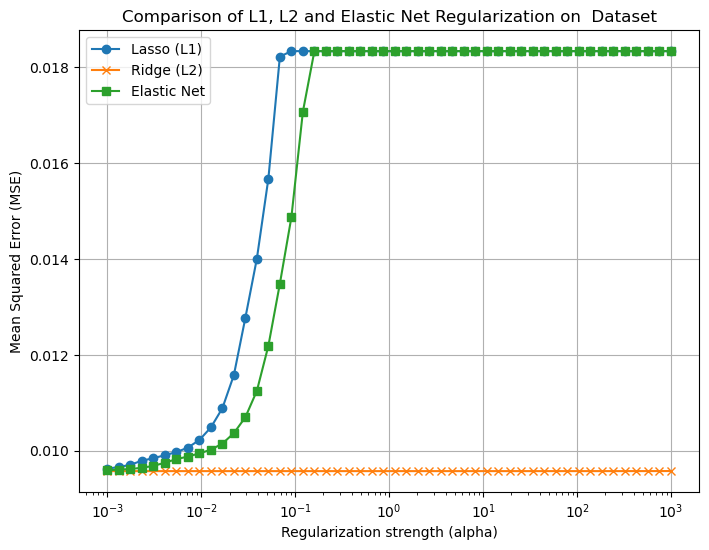


Best Lasso (L1) MSE for : 0.010 at alpha=0.001
Best Ridge (L2) MSE for : 0.010 at alpha=0.001
Best Elastic Net MSE for : 0.010 at alpha=0.001


In [32]:
compare_l1_l2_elastic(X_train_scaled, X_test_scaled, y_train, y_test, "")

##### Ridge

In [33]:
model = Ridge(alpha=0.001)
Ridge_model = model.fit(X_train_scaled, y_train)

y_pred = Ridge_model.predict(X_test_scaled)

metrics(y_test, y_pred)

Mean Squared Error (MSE): 0.009574
Root Mean Squared Error (RMSE): 0.097849
Mean Absolute Error (MAE): 0.064881
R² (Coefficient of Determination): 0.4778


##### Lasso

In [34]:
model = Lasso(alpha=0.001)
Lasso_model = model.fit(X_train_scaled, y_train)

y_pred = Lasso_model.predict(X_test_scaled)

metrics(y_test, y_pred)

Mean Squared Error (MSE): 0.009628
Root Mean Squared Error (RMSE): 0.098121
Mean Absolute Error (MAE): 0.064953
R² (Coefficient of Determination): 0.4749


##### ElasticNet

In [35]:
model = ElasticNet(alpha=0.001, l1_ratio=1)
EN_model = model.fit(X_train_scaled, y_train)

y_pred = EN_model.predict(X_test_scaled)

metrics(y_test, y_pred)

Mean Squared Error (MSE): 0.009628
Root Mean Squared Error (RMSE): 0.098121
Mean Absolute Error (MAE): 0.064953
R² (Coefficient of Determination): 0.4749


#### (iii) Bayesian Regression

In [36]:
model = BayesianRidge()
Bayesian_model = model.fit(X_train_scaled, y_train)

y_pred = Bayesian_model.predict(X_test_scaled)

metrics(y_test, y_pred)

Mean Squared Error (MSE): 0.009574
Root Mean Squared Error (RMSE): 0.097849
Mean Absolute Error (MAE): 0.064881
R² (Coefficient of Determination): 0.4778


#### (iv) Regularization

Regularization has no benefit in this case. 

Reasons:

No overfitting:

In [37]:
# Ridge: Test and Train prediction comparison 
y_pred = Ridge_model.predict(X_test_scaled)
print("Metrics for test data:")
metrics(y_test, y_pred)

print("")

y_pred = Ridge_model.predict(X_train_scaled)
print("Metrics for train data:")
metrics(y_train, y_pred)

Metrics for test data:
Mean Squared Error (MSE): 0.009574
Root Mean Squared Error (RMSE): 0.097849
Mean Absolute Error (MAE): 0.064881
R² (Coefficient of Determination): 0.4778

Metrics for train data:
Mean Squared Error (MSE): 0.009924
Root Mean Squared Error (RMSE): 0.099620
Mean Absolute Error (MAE): 0.065165
R² (Coefficient of Determination): 0.4616


Standardization:

In [38]:
y_pred = Ridge_model.predict(X_test_scaled)

print("R² for scaled data:", r2_score(y_test, y_pred))

print()

model = Ridge(alpha=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("R² for not scaled data:", r2_score(y_test, y_pred))

R² for scaled data: 0.4778341291951326

R² for not scaled data: 0.4778269502126672


Conclusion: L1 & L2 norms are not helping because the model is already well-behaved. there is no overfitting, and the features aren't causing instability in coefficient estimation.

### 5.3 Non Linear Models 

#### (i) k-NN

In [39]:
knn = KNeighborsRegressor(n_neighbors=5)
knn_model = knn.fit(X_train_scaled, y_train)

y_pred = knn_model.predict(X_test_scaled)

metrics(y_test, y_pred)

Mean Squared Error (MSE): 0.008317
Root Mean Squared Error (RMSE): 0.091199
Mean Absolute Error (MAE): 0.059590
R² (Coefficient of Determination): 0.5464


#### (ii) Random Forest Regressor

In [40]:
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split = 10,
    min_samples_leaf = 4,
    random_state=43,
    n_jobs=-1         
)
RF_model = model.fit(X_train_scaled, y_train)

y_pred = RF_model.predict(X_test_scaled)

metrics(y_test, y_pred)

Mean Squared Error (MSE): 0.006829
Root Mean Squared Error (RMSE): 0.082635
Mean Absolute Error (MAE): 0.054979
R² (Coefficient of Determination): 0.6276


#### (iii) XGBoost

In [41]:


# Create and fit the model
xgb = XGBRegressor(
    n_estimators=1000,     # number of trees
    learning_rate=0.05,   # shrinkage step
    max_depth=10,          # tree depth
    subsample=0.8,        # row sampling
    colsample_bytree=0.8, # feature sampling
    random_state=43
)
xgb_model = xgb.fit(X_train_scaled, y_train)

# Predict
y_pred = xgb_model.predict(X_test_scaled)

# Evaluate
metrics(y_test, y_pred)


Mean Squared Error (MSE): 0.006739
Root Mean Squared Error (RMSE): 0.082091
Mean Absolute Error (MAE): 0.054228
R² (Coefficient of Determination): 0.6325


### 5.4 Boundaries

#### (i) Linear Models

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


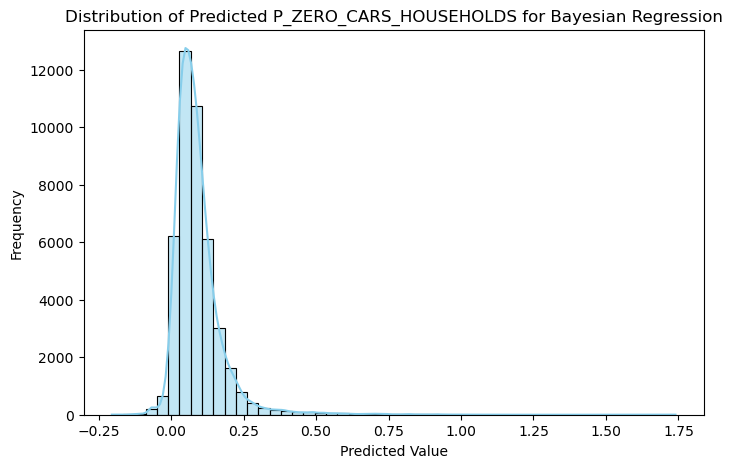

In [42]:
y_pred = Bayesian_model.predict(X_test_scaled)

# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(y_pred, bins=50, kde=True, color='skyblue')
plt.title("Distribution of Predicted P_ZERO_CARS_HOUSEHOLDS for Bayesian Regression")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.show()



There are predictions in Linear Regression which are negative or above 1.0. These are wrong because percentage has a boundary from 0 to 1

#### (ii) Non Linear Models

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


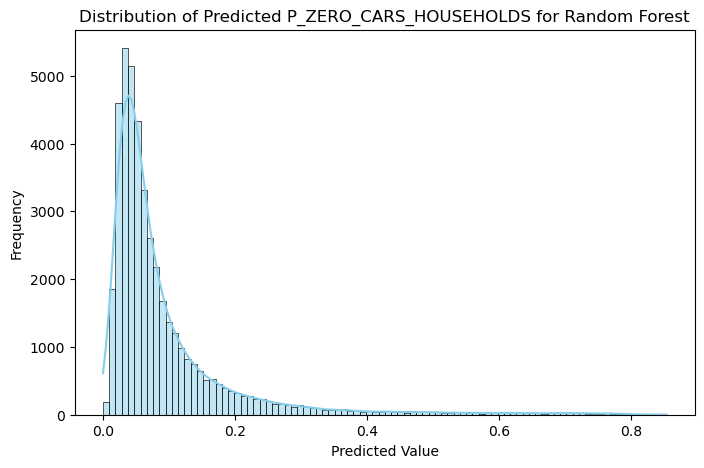

In [43]:
y_pred = RF_model.predict(X_test_scaled)

# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(y_pred, bins=90, kde=True, color='skyblue')
plt.title("Distribution of Predicted P_ZERO_CARS_HOUSEHOLDS for Random Forest")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.show()




The random forest and KNN model finds the right boundaries

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


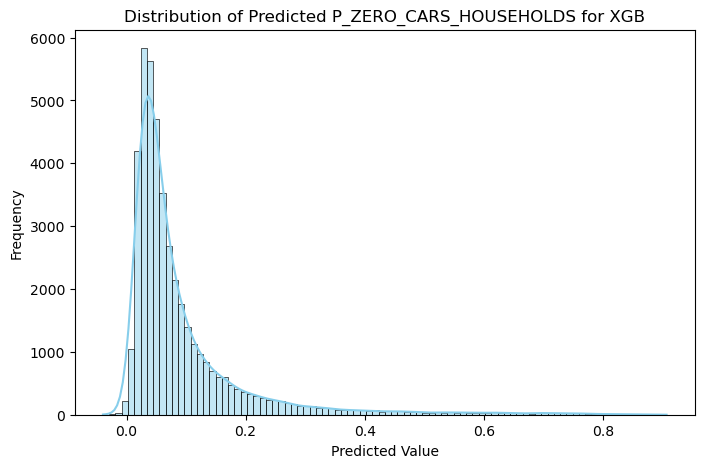

In [44]:
y_pred = xgb_model.predict(X_test_scaled)

# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(y_pred, bins=90, kde=True, color='skyblue')
plt.title("Distribution of Predicted P_ZERO_CARS_HOUSEHOLDS for XGB")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.show()

XGB has also problems finding the boundaries but it is not as bad as the linear models

### 5.5 Skewed Target 

(P_ZERO_CARS_HOUSEHOLDS) has a very skewed distribution
(Mean ≈ 0.09, Median ≈ 0.04, Max = 1.0)

#### (i) Test data

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


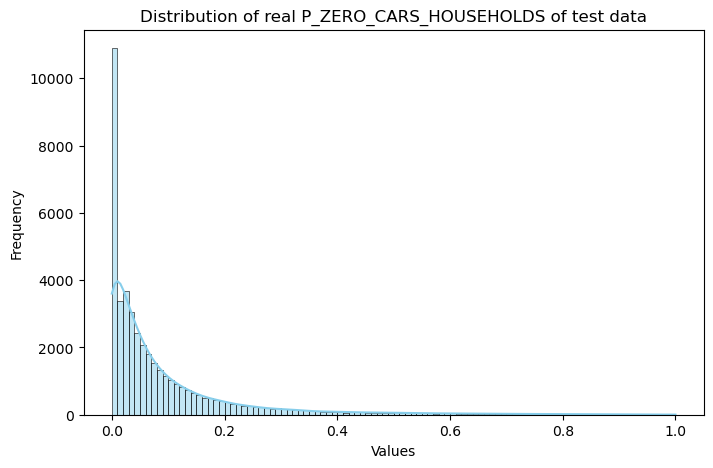

In [45]:
# Plot distribution of P_ZERO_CARS_HOUSEHOLDS Test
plt.figure(figsize=(8, 5))
sns.histplot(y_test, bins=100, kde=True, color='skyblue')
plt.title("Distribution of real P_ZERO_CARS_HOUSEHOLDS of test data")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()

The data is skewed with a high number of records with 0 values. These are rural areas with no transit. 

#### (ii) Random Forest

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


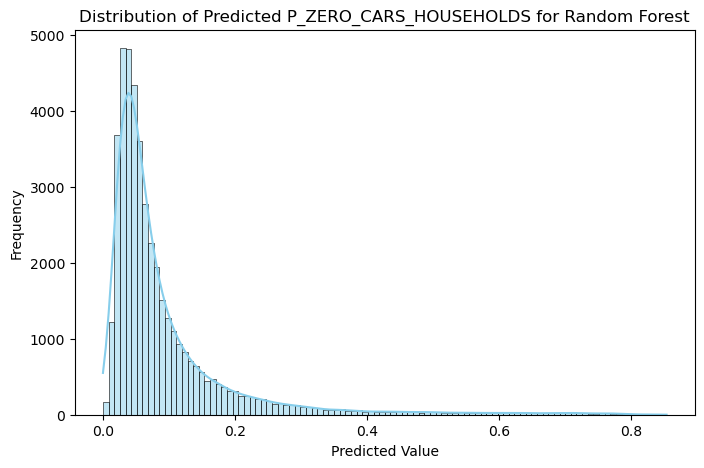

In [46]:
y_pred = RF_model.predict(X_test_scaled)

# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(y_pred, bins=100, kde=True, color='skyblue')
plt.title("Distribution of Predicted P_ZERO_CARS_HOUSEHOLDS for Random Forest")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.show()

The model does not predict these high numbers of records with 0 values

### 5.6 Coefficient strength and uncertainty

100%|███████████████████████████████████████| 1000/1000 [01:06<00:00, 15.05it/s]


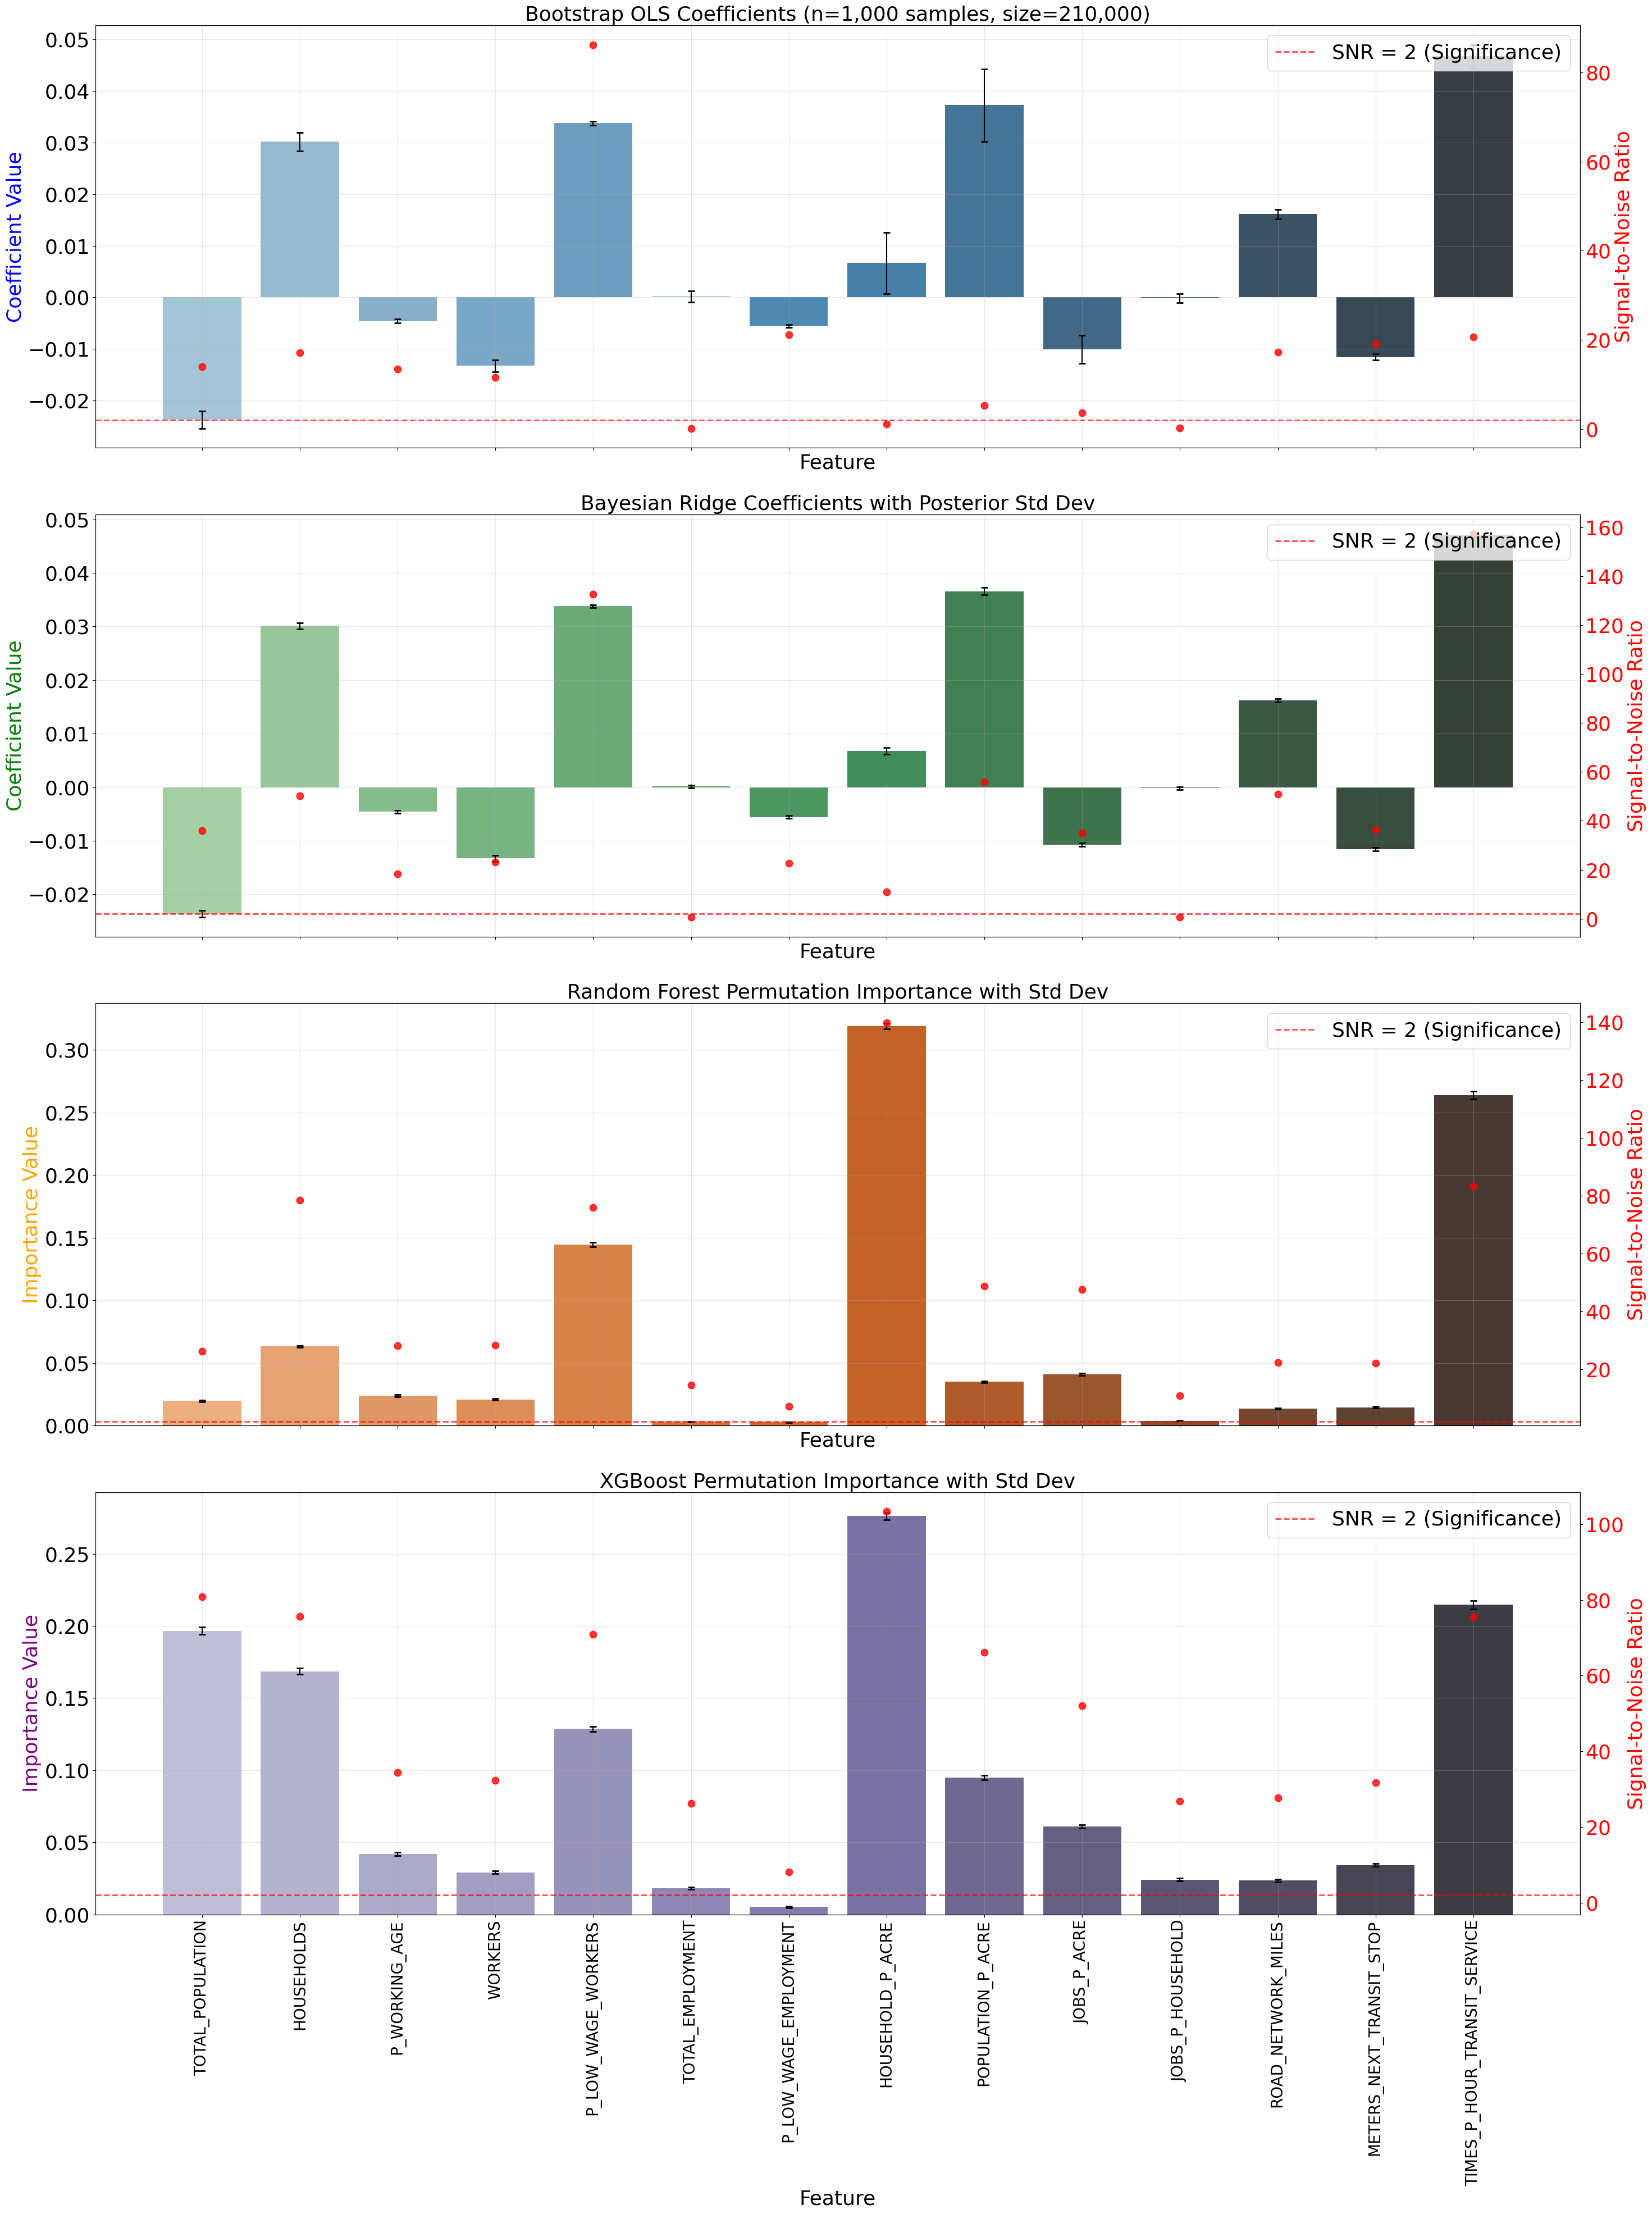


=== SNR Summary Statistics ===
Bootstrap OLS - Mean SNR: 16.47, Features with SNR ≥ 2: 11/14
Bayesian Ridge - Mean SNR: 45.06, Features with SNR ≥ 2: 12/14
Random Forest - Mean SNR: 45.28, Features with SNR ≥ 2: 14/14
XGBoost - Mean SNR: 50.85, Features with SNR ≥ 2: 14/14


In [47]:
plt.rcParams.update({
    'font.size': 26,          # Base font size
    'axes.titlesize': 26,     # Subplot titles
    'axes.labelsize': 26,     # Axis labels
    'xtick.labelsize': 20,    # X-axis tick labels
    'ytick.labelsize': 26,    # Y-axis tick labels
    'legend.fontsize': 26,    # Legend (if any)
    'figure.titlesize': 26    # Main figure title
})

# =============================================================================
# Bootstrap OLS coefficients and standard errors
# =============================================================================
ols_mean_coefs, ols_std_errors, all_bootstrap_coefs = bootstrap_ols_coefficients(
    X_train_scaled, y_train
)

ols_summary = pd.DataFrame({
    'Feature': X_train.columns,
    'Coef': ols_mean_coefs,
    'Std Err': ols_std_errors,
    'CV': ols_std_errors / np.abs(ols_mean_coefs),  # Coefficient of variation
    'SNR': np.abs(ols_mean_coefs) / ols_std_errors  # Signal-to-Noise Ratio
})

# =============================================================================
# Bayesian Ridge coefficients and std dev
# =============================================================================
coef_summary = pd.DataFrame({
    'Feature': X_train.columns,
    'Mean Coef': Bayesian_model.coef_,
    'Std Dev': np.sqrt(np.diag(Bayesian_model.sigma_)),
    'SNR': np.abs(Bayesian_model.coef_) / np.sqrt(np.diag(Bayesian_model.sigma_))
})

# =============================================================================
# Random Forest permutation importance
# =============================================================================
result = permutation_importance(
    RF_model, X_test_scaled, y_test,
    n_repeats=30,
    random_state=43,
    n_jobs=-1
)
df_perm = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std,
    'SNR': result.importances_mean / result.importances_std
})

# =============================================================================
# XGBoost model & permutation importance
# =============================================================================
result_xgb = permutation_importance(
    xgb_model, X_test_scaled, y_test,
    n_repeats=30,
    random_state=43,
    n_jobs=-1
)
df_perm_xgb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance Mean': result_xgb.importances_mean,
    'Importance Std': result_xgb.importances_std,
    'SNR': result_xgb.importances_mean / result_xgb.importances_std
})

# =============================================================================
# Plots
# =============================================================================
fig, axes = plt.subplots(4, 1, figsize=(30, 40), sharex=True)

# --- 1. Bootstrap OLS ---
sns.barplot(
    data=ols_summary,
    x='Feature', y='Coef',
    ax=axes[0], palette='Blues_d', errorbar=None
)
axes[0].errorbar(
    x=np.arange(len(ols_summary)),
    y=ols_summary['Coef'],
    yerr=ols_summary['Std Err'],
    fmt='none', c='black', capsize=4, capthick=2
)
axes[0].set_title(f'Bootstrap OLS Coefficients (n={N_BOOTSTRAP_SAMPLES:,} samples, size={BOOTSTRAP_SAMPLE_SIZE:,})')
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylabel('Coefficient Value', color='blue')
ax0_twin = axes[0].twinx()
ax0_twin.scatter(np.arange(len(ols_summary)), ols_summary['SNR'], color='red', s=80, alpha=0.8, marker='o')
ax0_twin.axhline(y=2, color='red', linestyle='--', alpha=0.7, linewidth=2, label='SNR = 2 (Significance)')
ax0_twin.set_ylabel('Signal-to-Noise Ratio', color='red')
ax0_twin.tick_params(axis='y', labelcolor='red')
ax0_twin.legend(loc='upper right')

# --- 2. Bayesian Ridge ---
sns.barplot(
    data=coef_summary,
    x='Feature', y='Mean Coef',
    ax=axes[1], palette='Greens_d', errorbar=None
)
axes[1].errorbar(
    x=np.arange(len(coef_summary)),
    y=coef_summary['Mean Coef'],
    yerr=coef_summary['Std Dev'],
    fmt='none', c='black', capsize=4, capthick=2
)
axes[1].set_title('Bayesian Ridge Coefficients with Posterior Std Dev')
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylabel('Coefficient Value', color='green')
ax1_twin = axes[1].twinx()
ax1_twin.scatter(np.arange(len(coef_summary)), coef_summary['SNR'], color='red', s=80, alpha=0.8, marker='o')
ax1_twin.axhline(y=2, color='red', linestyle='--', alpha=0.7, linewidth=2, label='SNR = 2 (Significance)')
ax1_twin.set_ylabel('Signal-to-Noise Ratio', color='red')
ax1_twin.tick_params(axis='y', labelcolor='red')
ax1_twin.legend(loc='upper right')

# --- 3. Random Forest ---
sns.barplot(
    data=df_perm,
    x='Feature', y='Importance Mean',
    ax=axes[2], palette='Oranges_d', errorbar=None
)
axes[2].errorbar(
    x=np.arange(len(df_perm)),
    y=df_perm['Importance Mean'],
    yerr=df_perm['Importance Std'],
    fmt='none', c='black', capsize=4, capthick=2
)
axes[2].set_title('Random Forest Permutation Importance with Std Dev')
axes[2].tick_params(axis='x', rotation=90)
axes[2].grid(True, alpha=0.3)
axes[2].set_ylabel('Importance Value', color='orange')
ax2_twin = axes[2].twinx()
ax2_twin.scatter(np.arange(len(df_perm)), df_perm['SNR'], color='red', s=80, alpha=0.8, marker='o')
ax2_twin.axhline(y=2, color='red', linestyle='--', alpha=0.7, linewidth=2, label='SNR = 2 (Significance)')
ax2_twin.set_ylabel('Signal-to-Noise Ratio', color='red')
ax2_twin.tick_params(axis='y', labelcolor='red')
ax2_twin.legend(loc='upper right')

# --- 4. XGBoost ---
sns.barplot(
    data=df_perm_xgb,
    x='Feature', y='Importance Mean',
    ax=axes[3], palette='Purples_d', errorbar=None
)
axes[3].errorbar(
    x=np.arange(len(df_perm_xgb)),
    y=df_perm_xgb['Importance Mean'],
    yerr=df_perm_xgb['Importance Std'],
    fmt='none', c='black', capsize=4, capthick=2
)
axes[3].set_title('XGBoost Permutation Importance with Std Dev')
axes[3].tick_params(axis='x', rotation=90)
axes[3].grid(True, alpha=0.3)
axes[3].set_ylabel('Importance Value', color='purple')
ax3_twin = axes[3].twinx()
ax3_twin.scatter(np.arange(len(df_perm_xgb)), df_perm_xgb['SNR'], color='red', s=80, alpha=0.8, marker='o')
ax3_twin.axhline(y=2, color='red', linestyle='--', alpha=0.7, linewidth=2, label='SNR = 2 (Significance)')
ax3_twin.set_ylabel('Signal-to-Noise Ratio', color='red')
ax3_twin.tick_params(axis='y', labelcolor='red')
ax3_twin.legend(loc='upper right')

plt.tight_layout()
plt.show()

# =============================================================================
# SNR Summary Statistics
# =============================================================================
print("\n=== SNR Summary Statistics ===")
print(f"Bootstrap OLS - Mean SNR: {ols_summary['SNR'].mean():.2f}, Features with SNR ≥ 2: {(ols_summary['SNR'] >= 2).sum()}/{len(ols_summary)}")
print(f"Bayesian Ridge - Mean SNR: {coef_summary['SNR'].mean():.2f}, Features with SNR ≥ 2: {(coef_summary['SNR'] >= 2).sum()}/{len(coef_summary)}")
print(f"Random Forest - Mean SNR: {df_perm['SNR'].mean():.2f}, Features with SNR ≥ 2: {(df_perm['SNR'] >= 2).sum()}/{len(df_perm)}")
print(f"XGBoost - Mean SNR: {df_perm_xgb['SNR'].mean():.2f}, Features with SNR ≥ 2: {(df_perm_xgb['SNR'] >= 2).sum()}/{len(df_perm_xgb)}")


In [48]:
#OLS
print(ols_summary)

                         Feature      Coef   Std Err         CV        SNR
0               TOTAL_POPULATION -0.023740  0.001697   0.071497  13.986582
1                     HOUSEHOLDS  0.030187  0.001771   0.058670  17.044452
2                  P_WORKING_AGE -0.004591  0.000342   0.074513  13.420554
3                        WORKERS -0.013268  0.001153   0.086900  11.507449
4             P_LOW_WAGE_WORKERS  0.033798  0.000392   0.011596  86.236070
5               TOTAL_EMPLOYMENT  0.000106  0.001088  10.312891   0.096966
6          P_LOW_WAGE_EMPLOYMENT -0.005557  0.000263   0.047409  21.093154
7               HOUSEHOLD_P_ACRE  0.006656  0.005904   0.887072   1.127304
8              POPULATION_P_ACRE  0.037272  0.007055   0.189278   5.283245
9                    JOBS_P_ACRE -0.010050  0.002734   0.272061   3.675645
10              JOBS_P_HOUSEHOLD -0.000172  0.000869   5.047759   0.198108
11            ROAD_NETWORK_MILES  0.016119  0.000937   0.058123  17.204772
12      METERS_NEXT_TRANS

In [49]:
#Bayesian
print(coef_summary)

                         Feature  Mean Coef   Std Dev         SNR
0               TOTAL_POPULATION  -0.023634  0.000657   35.992454
1                     HOUSEHOLDS   0.030117  0.000601   50.140869
2                  P_WORKING_AGE  -0.004590  0.000250   18.361982
3                        WORKERS  -0.013281  0.000575   23.089780
4             P_LOW_WAGE_WORKERS   0.033777  0.000255  132.536504
5               TOTAL_EMPLOYMENT   0.000143  0.000270    0.531812
6          P_LOW_WAGE_EMPLOYMENT  -0.005564  0.000245   22.710183
7               HOUSEHOLD_P_ACRE   0.006819  0.000625   10.917737
8              POPULATION_P_ACRE   0.036573  0.000654   55.953739
9                    JOBS_P_ACRE  -0.010686  0.000304   35.096191
10              JOBS_P_HOUSEHOLD  -0.000171  0.000246    0.695335
11            ROAD_NETWORK_MILES   0.016236  0.000319   50.909196
12      METERS_NEXT_TRANSIT_STOP  -0.011605  0.000318   36.488771
13  TIMES_P_HOUR_TRANSIT_SERVICE   0.047039  0.000299  157.422042


In [50]:
# Random Forest
print(df_perm)

                         Feature  Importance Mean  Importance Std         SNR
0               TOTAL_POPULATION         0.019637        0.000748   26.247381
1                     HOUSEHOLDS         0.063097        0.000803   78.534834
2                  P_WORKING_AGE         0.023938        0.000849   28.205637
3                        WORKERS         0.020879        0.000737   28.335256
4             P_LOW_WAGE_WORKERS         0.144389        0.001902   75.925391
5               TOTAL_EMPLOYMENT         0.003055        0.000210   14.560924
6          P_LOW_WAGE_EMPLOYMENT         0.002511        0.000347    7.232003
7               HOUSEHOLD_P_ACRE         0.318812        0.002279  139.884147
8              POPULATION_P_ACRE         0.034931        0.000717   48.728198
9                    JOBS_P_ACRE         0.040872        0.000859   47.571684
10              JOBS_P_HOUSEHOLD         0.003848        0.000351   10.966272
11            ROAD_NETWORK_MILES         0.013463        0.00060

In [51]:
#XGBoost
print(df_perm_xgb)

                         Feature  Importance Mean  Importance Std         SNR
0               TOTAL_POPULATION         0.196627        0.002430   80.916224
1                     HOUSEHOLDS         0.168561        0.002228   75.664528
2                  P_WORKING_AGE         0.041862        0.001219   34.348101
3                        WORKERS         0.029206        0.000904   32.297703
4             P_LOW_WAGE_WORKERS         0.128629        0.001816   70.841991
5               TOTAL_EMPLOYMENT         0.018199        0.000693   26.242143
6          P_LOW_WAGE_EMPLOYMENT         0.005167        0.000636    8.118209
7               HOUSEHOLD_P_ACRE         0.276116        0.002671  103.392041
8              POPULATION_P_ACRE         0.094865        0.001434   66.131116
9                    JOBS_P_ACRE         0.060801        0.001167   52.101866
10              JOBS_P_HOUSEHOLD         0.024154        0.000899   26.856535
11            ROAD_NETWORK_MILES         0.023426        0.00084

### 5.7 Model uncertainty

In [52]:
from sklearn.utils import resample
import numpy as np
import statsmodels.api as sm
import xgboost as xgb

# --- OLS Model ---
# Add constant (intercept)
X_train_const = sm.add_constant(X_train_scaled)
X_test_const = sm.add_constant(X_test_scaled)

# Fit OLS
ols_model = sm.OLS(y_train, X_train_const).fit()

# Get OLS predictions with standard errors of prediction
ols_pred = ols_model.get_prediction(X_test_const)
ols_pred_summary = ols_pred.summary_frame(alpha=0.05)  # 95% PI

# Extract mean prediction and standard deviation of prediction
y_pred_mean_ols = ols_pred_summary['mean'].values
y_pred_std_ols = (ols_pred_summary['obs_ci_upper'] - ols_pred_summary['obs_ci_lower']) / (2 * 1.96)

# --- Bayesian Ridge prediction + uncertainty ---
y_pred_mean_bayes, y_pred_std_bayes = Bayesian_model.predict(X_test_scaled, return_std=True)

# --- Random Forest prediction + uncertainty ---
all_tree_preds = np.stack([tree.predict(X_test_scaled) for tree in RF_model.estimators_], axis=0)
y_pred_mean_rf = np.mean(all_tree_preds, axis=0)
y_pred_std_rf = np.std(all_tree_preds, axis=0)

# --- XGBoost prediction + uncertainty (bootstrap) ---
n_boot = 50  # number of bootstrap models
all_preds_xgb = []

for _ in range(n_boot):
    X_resampled, y_resampled = resample(X_train_scaled, y_train)
    model = xgb.XGBRegressor(**xgb_model.get_params())
    model.fit(X_resampled, y_resampled)
    all_preds_xgb.append(model.predict(X_test_scaled))

all_preds_xgb = np.stack(all_preds_xgb, axis=0)
y_pred_mean_xgb = np.mean(all_preds_xgb, axis=0)
y_pred_std_xgb = np.std(all_preds_xgb, axis=0)

# --- Function to calculate coverage and average width ---
def uncertainty_metrics(y_true, y_pred_mean, y_pred_std, n_std=2):
    lower = y_pred_mean - n_std * y_pred_std
    upper = y_pred_mean + n_std * y_pred_std
    coverage = np.mean((y_true >= lower) & (y_true <= upper))
    avg_width = np.mean(upper - lower)
    mean_std = np.mean(y_pred_std)
    median_std = np.median(y_pred_std)
    return coverage, avg_width, mean_std, median_std

# --- Calculate metrics ---
coverage_ols, width_ols, mean_std_ols, median_std_ols = uncertainty_metrics(
    y_test.values, y_pred_mean_ols, y_pred_std_ols)

coverage_bayes, width_bayes, mean_std_bayes, median_std_bayes = uncertainty_metrics(
    y_test.values, y_pred_mean_bayes, y_pred_std_bayes)

coverage_rf, width_rf, mean_std_rf, median_std_rf = uncertainty_metrics(
    y_test.values, y_pred_mean_rf, y_pred_std_rf)

coverage_xgb, width_xgb, mean_std_xgb, median_std_xgb = uncertainty_metrics(
    y_test.values, y_pred_mean_xgb, y_pred_std_xgb)

# --- Print results ---
print("OLS Prediction Uncertainty:")
print(f"  Coverage (±2 std): {coverage_ols:.3f}")
print(f"  Avg Interval Width: {width_ols:.4f}")
print(f"  Mean Predictive Std: {mean_std_ols:.5f}")
print(f"  Median Predictive Std: {median_std_ols:.5f}\n")

print("Bayesian Ridge Prediction Uncertainty:")
print(f"  Coverage (±2 std): {coverage_bayes:.3f}")
print(f"  Avg Interval Width: {width_bayes:.4f}")
print(f"  Mean Predictive Std: {mean_std_bayes:.5f}")
print(f"  Median Predictive Std: {median_std_bayes:.5f}\n")

print("Random Forest Prediction Uncertainty:")
print(f"  Coverage (±2 std): {coverage_rf:.3f}")
print(f"  Avg Interval Width: {width_rf:.4f}")
print(f"  Mean Predictive Std: {mean_std_rf:.5f}")
print(f"  Median Predictive Std: {median_std_rf:.5f}\n")

print("XGBoost Prediction Uncertainty (bootstrap):")
print(f"  Coverage (±2 std): {coverage_xgb:.3f}")
print(f"  Avg Interval Width: {width_xgb:.4f}")
print(f"  Mean Predictive Std: {mean_std_xgb:.5f}")
print(f"  Median Predictive Std: {median_std_xgb:.5f}")


OLS Prediction Uncertainty:
  Coverage (±2 std): 0.953
  Avg Interval Width: 0.3985
  Mean Predictive Std: 0.09963
  Median Predictive Std: 0.09962

Bayesian Ridge Prediction Uncertainty:
  Coverage (±2 std): 0.953
  Avg Interval Width: 0.3985
  Mean Predictive Std: 0.09963
  Median Predictive Std: 0.09963

Random Forest Prediction Uncertainty:
  Coverage (±2 std): 0.926
  Avg Interval Width: 0.2295
  Mean Predictive Std: 0.05737
  Median Predictive Std: 0.04746

XGBoost Prediction Uncertainty (bootstrap):
  Coverage (±2 std): 0.302
  Avg Interval Width: 0.0567
  Mean Predictive Std: 0.01417
  Median Predictive Std: 0.01113


#### Smaller intervals and special areas of prediction range

In [53]:
# Function to compute fraction within ±3% absolute error
def within_3_percent(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) <= 0.03)

# True values for test set
y_true = y_test.values

# Predictions for test set
y_pred_ols = ols_model.predict(sm.add_constant(X_test_scaled))
y_pred_bayes = Bayesian_model.predict(X_test_scaled)
y_pred_rf = RF_model.predict(X_test_scaled)
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Calculate fraction within ±3% absolute error
acc_ols = within_3_percent(y_true, y_pred_ols)
acc_bayes = within_3_percent(y_true, y_pred_bayes)
acc_rf = within_3_percent(y_true, y_pred_rf)
acc_xgb = within_3_percent(y_true, y_pred_xgb)

# Print results
print("Prediction accuracy within ±3% absolute error:")
print(f"OLS:            {acc_ols:.3f}")
print(f"Bayesian Ridge: {acc_bayes:.3f}")
print(f"Random Forest:  {acc_rf:.3f}")
print(f"XGBoost:        {acc_xgb:.3f}")

Prediction accuracy within ±3% absolute error:
OLS:            0.351
Bayesian Ridge: 0.351
Random Forest:  0.428
XGBoost:        0.441


## 9 References

Links:
https://www.epa.gov/smartgrowth/smart-location-mapping#SLD,
https://catalog.data.gov/dataset/smart-location-database8